# Preparations

##  Modules Required

In [53]:
# !pip install numpy pandas geotext tweet-preprocessor nltk wordcloud plotly pycountry

## Mount Google Drive

In [54]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import required modules

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob
from geotext import GeoText
import nltk
import plotly.graph_objects as go
from wordcloud import WordCloud
import pycountry

In [56]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mukul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Configurations

In [57]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'spacex'
TARGET_NAME = TARGET
if IS_SAMPLE_ANALYSIS:
    TARGET_NAME += '_sample'
FIGURE_SIZE = (12,7)
# FOLDER_LOCATION = '/content/drive/My Drive/Projects/Twitter Data Sentiment Analysis/data/'
# FOLDER_LOCATION = '/content/drive/My Drive/DM/'
FOLDER_LOCATION = '../data/'
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Load Data

In [58]:
tweets = pd.read_csv(FOLDER_LOCATION + TARGET_NAME + '.csv', index_col=0, converters={i: str for i in range(0, 8)})

In [59]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,source_device,clean_text,country
9449,"Automakers, Tesla and SpaceX Explore Working o...",1584860520,peetm,1241621130160615425,1241621130160615425,peetm,"automakers, tesla and spacex elore working on ...",US
9450,@HankMeyerOKC @answerswithjoe @spacexonaut @Er...,1584861038,Nitro_orava,1241623301715263488,1241623301715263488,Twitter Web App,you can surely stand on a tower that's lower t...,NaN
9451,@elonmusk @SpaceX @SpaceXStarlink #elonmusk #s...,1584861038,desertgranite,1241623303707430912,1241623303707430912,Twitter for Android,elonmusk spacex after this crisis...my objecti...,NaN
9452,CA Governor Newsom’s State update today cited ...,1584861160,mi_n50,1241530353283555329,1241623817035923456,Twitter Web App,ca governor newsom s state update today cited ...,NaN
9453,CA Governor Newsom’s State update today cited ...,1584861163,Mr_aminua,1241530353283555329,1241623826674352128,Twitter for Android,ca governor newsom s state update today cited ...,NG


# Feature Creation

## 'is_retweet' from 'tweet_source' and 'tweet_id'

In [60]:
def is_retweet(x):
    return x[0] != x[1]

In [61]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [62]:
tweets[['tweet_source','tweet_id','is_retweet']].tail()

,tweet_source,tweet_id,is_retweet
9449,1241621130160615425,1241621130160615425,False
9450,1241623301715263488,1241623301715263488,False
9451,1241623303707430912,1241623303707430912,False
9452,1241530353283555329,1241623817035923456,True
9453,1241530353283555329,1241623826674352128,True


## 'datetime' from 'timestamp'

In [63]:
def get_datetime(ts):
    return datetime.fromtimestamp(int(ts))

In [64]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

# Analysis

## Tweet distribution over time

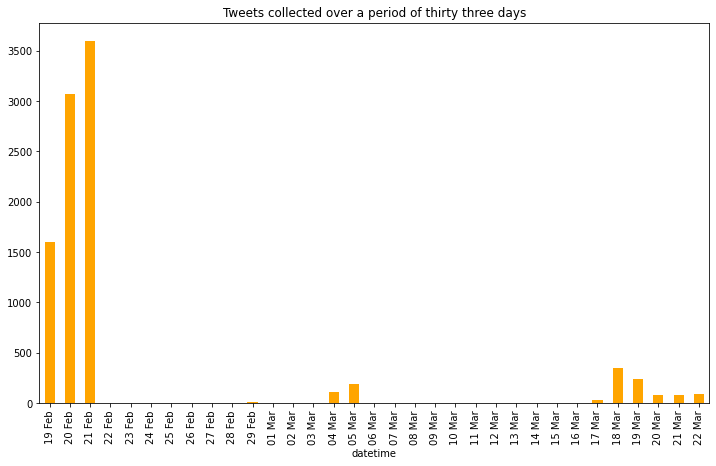

In [65]:
tweets_over_time = tweets[['datetime','timestamp']].groupby(pd.Grouper(key='datetime', freq='D')).size()
graph = tweets_over_time.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweets collected over a period of thirty three days')
graph.set_xticklabels(map(lambda x: x.strftime("%d %b"), tweets_over_time.index))
plt.show()

To see how peoples sentiment changes over time, data was collected over a period of 33 days in three batches. Each batch has data of roughly 60 to 120 hours.

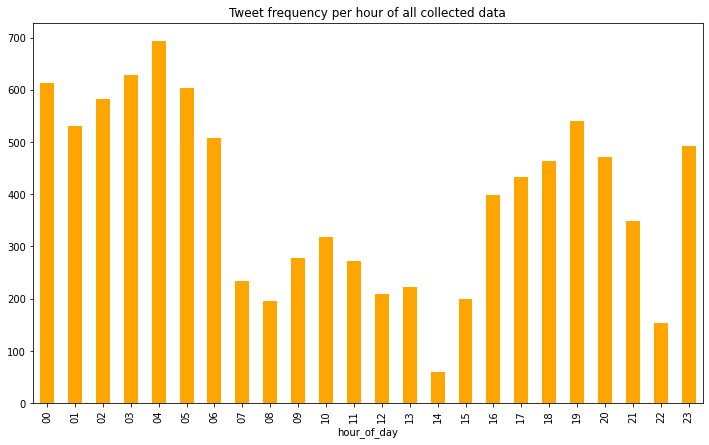

In [66]:
tweets['hour_of_day'] = tweets['datetime'].apply(lambda x: str(x)[11:13])
tweets[['hour_of_day','datetime']].groupby('hour_of_day').size().plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweet frequency per hour of all collected data')
plt.show()

Plotting number of tweets over 24 hours each day to understand when people tweet the most.

## Percentage of retweets in tweets

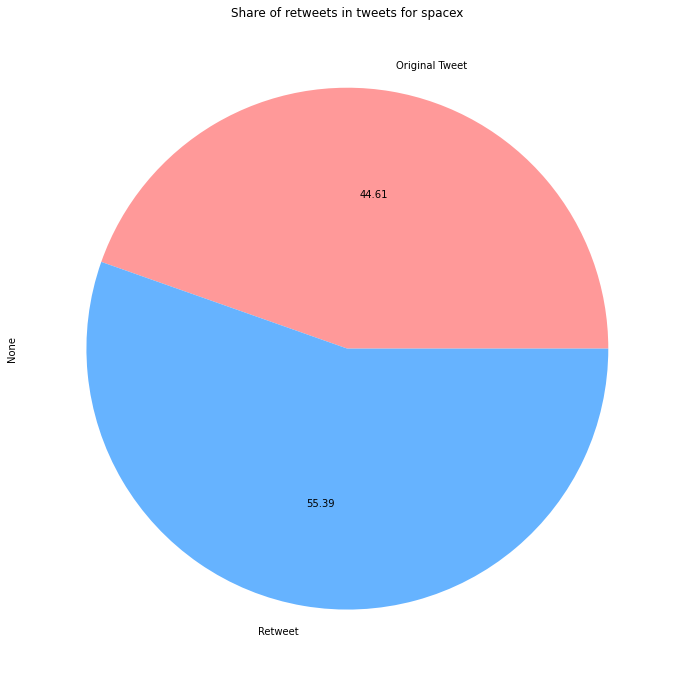

In [67]:
tweet_retweet_share = tweets[['is_retweet','user']].groupby('is_retweet').size()
tweet_retweet_share.index = ['Original Tweet', 'Retweet']
tweet_retweet_share.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Share of retweets in tweets for {TARGET}')
plt.show()

This chart shows that about half of our tweets are retweets. People retweet something when they endorse it, thus asserting the same sentiment as original tweet more strongly in our data.

## Analysis of tweet text

### Most used words

In [68]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_clean_text.append(word)
all_clean_text = ' '.join(all_clean_text)

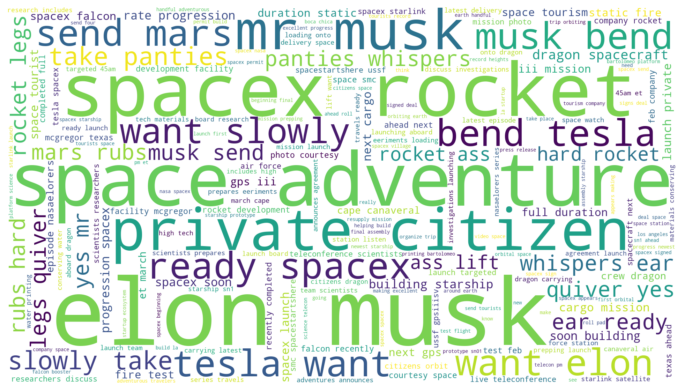

In [69]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_clean_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This wordcloud shows the most used words in tweets for this company. The wordcloud also makes collocations, showing words which are frequently used together.

Some other words can also be seen which had been trending during that time.

### Most used Hashtags

In [70]:
tokenizer = TweetTokenizer()

all_text = []
for text in tweets['text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_text.append(word)
all_text = ' '.join(all_text)

In [71]:
HASHTAG_PATTERN = re.compile(r'#\w*')
all_hashtags = ' '.join(HASHTAG_PATTERN.findall(str(all_text)))

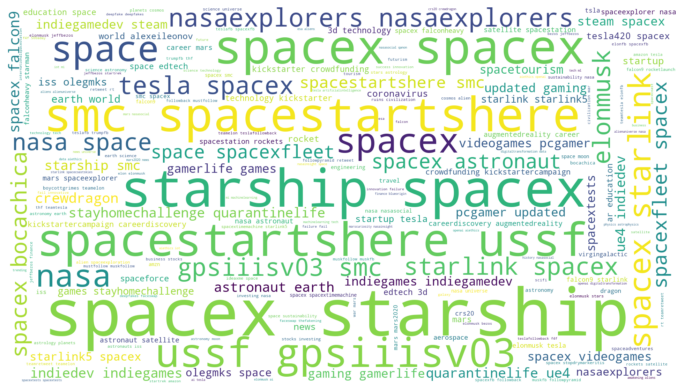

In [72]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_hashtags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [73]:
def get_sentiment(text):
    return TextBlob(text).sentiment

In [74]:
%%time
sentiment = tweets['clean_text'].apply(lambda x: get_sentiment(x))
tweets['polarity'] = sentiment.apply(lambda x: x[0])
tweets['subjectivity'] = sentiment.apply(lambda x: x[1])

CPU times: user 6.03 s, sys: 156 ms, total: 6.19 s
Wall time: 6.45 s


In [75]:
tweets[['text','polarity','subjectivity']].head()

,text,polarity,subjectivity
0,@DanielNewman @SpaceAdventures @SpaceX But sur...,0.152841,0.540972
1,CNN: SpaceX has signed a deal with a space tou...,0.100000,0.750000
2,Watch SpaceX attempt a rocket reusability reco...,0.136364,0.500000
3,SpaceX has signed a deal with a space tourism ...,0.100000,0.750000
4,@IsChinar I'm pretty sure #Spacex didnt exist ...,0.356250,0.740972


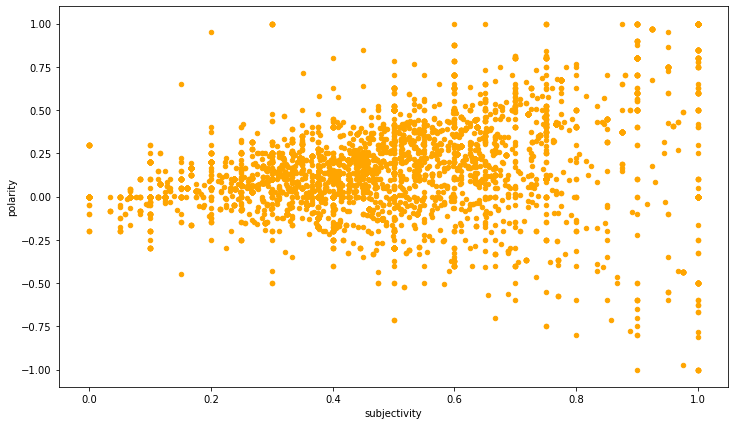

In [76]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE, color='orange')
plt.show()

From the above graph we can see, as the polarity becomes extreme, the subjectivity also increases. That is, more a person is opinionated, more subjective there views are.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea31e9bda0>,
      dtype=object)

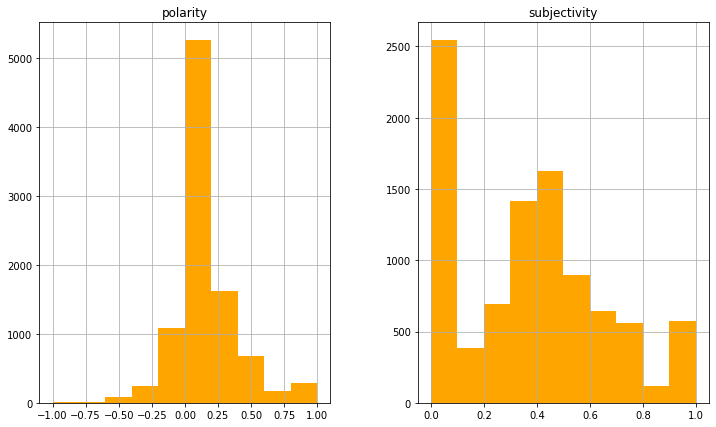

In [77]:
tweets[['polarity','subjectivity']].hist(figsize=FIGURE_SIZE, color='orange')

Histogram for polarity and subjectivity shows that, most tweets have a polarity score of around 0, with a bias towards positive values and subjectivity score many around 0 but more around 0.4 to 0.6. This shows that most tweets have a neutral sentimnt with some being positive and most tweets are subjective, that is, people are more emotionally involved with the brand.

### Sentiment Over Time

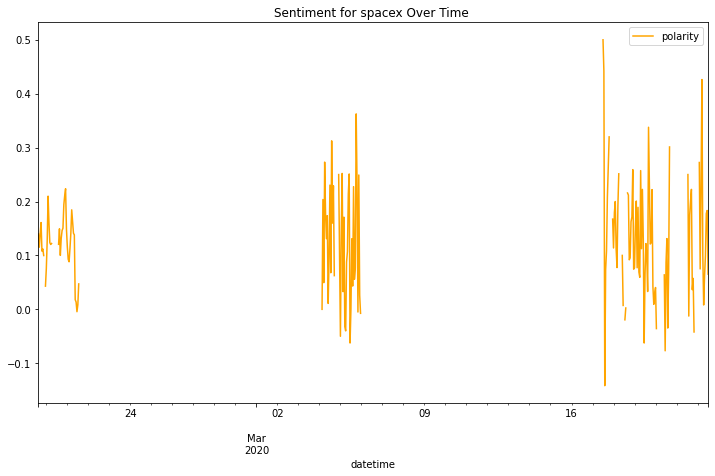

In [78]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H'))\
.mean().plot(figsize=FIGURE_SIZE, color='orange')
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

From the above graph we can see that the sentiment remains mostly positive over the period of 33 days. 

### Top Twitter Clients

In [79]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

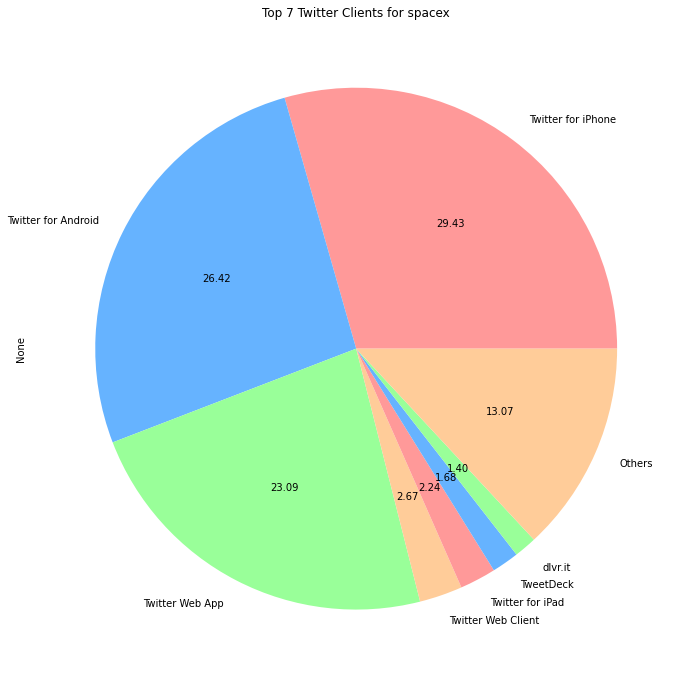

In [80]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others']))\
.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

This chart shows the most prefered twitter clients for people tweeting about this company.

### Average Sentiment of people using particular twitter clients

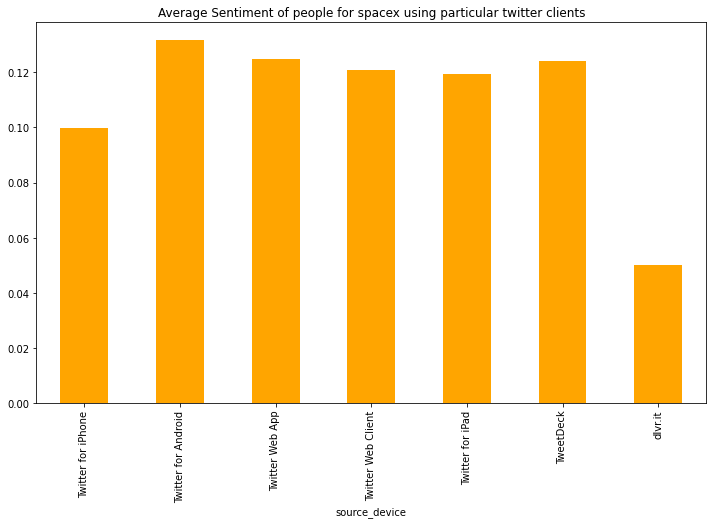

In [81]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:7]\
.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()

### Most tweeting countries

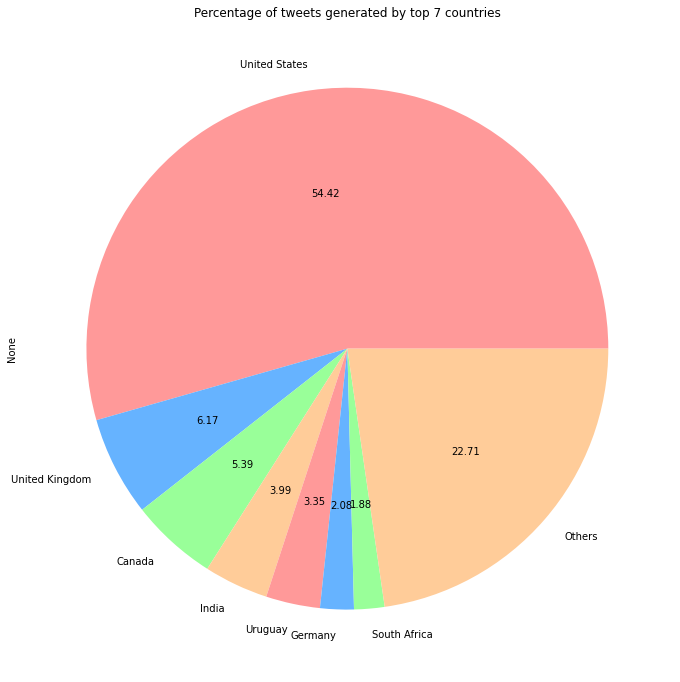

In [82]:
most_tweet_countries = tweets[['country','polarity']].groupby('country').agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[('polarity','size')]
top_7_countries = most_tweet_countries[:7]
top_7_countries.index = top_7_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries = top_7_countries.append(pd.Series(most_tweet_countries[7:].sum(), index=['Others']))
most_tweet_countries.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title('Percentage of tweets generated by top 7 countries')
plt.show()

### Sentiment of people in countries tweeting most

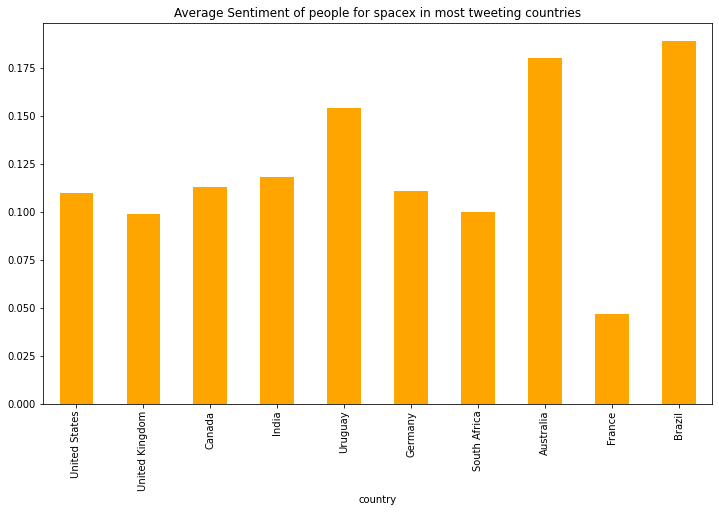

In [83]:
most_tweet_countries = tweets[['country','polarity']].groupby('country')\
.agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[:10]
most_tweet_countries.index = most_tweet_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries[('polarity','mean')].plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} in most tweeting countries')
plt.show()

From the above bar chart, we can see that people in Australia and Brazil have more positive sentiment for spacex. But for some reason people in France don't like the company as much. Overall, all countries sentiment is positive for spacex.